In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D

## Formulas

The evolution is done as follows: given an  approximation at time $t$, we construct a new approximation at time $t + h$ by 
running a cross method on the following formula:

$$\rho(x, t + h) = \left(1 - h \mathrm{Tr}\left(\frac{\partial g}{\partial x}\right)\right) E_{\epsilon} \rho(x - h g(x) + \sqrt{h} \epsilon, t)$$

This time stepping can be implemented via the cross method

In [4]:
def logrho0(x):
    '''
    Log likelihood for normal distribution
    '''
    
    res = np.einsum('ik,ik->k', x, x)
    return res
    #return np.diag(x.T@x)

def euler_sde(x0, A, h, noise):
    x1 = x0 + h*A@x0 + np.sqrt(h)*np.random.randn(*x0.shape)*noise
    return x1

def estimate_log_rho(w0, nsamples, nsteps, A, h, noise):
    res = []
    d = w0.shape[1]
    K = w0.shape[0]
    w = w0.T
    w = np.repeat(w.reshape((d, -1)), nsamples, axis=1)
    for i in range(nsteps):
        w = euler_sde(w, A, h, noise) 
    log_rho_val = logrho0(w) # Will be replaced by the previous approximation
    log_rho_val = np.reshape(log_rho_val, (K, nsamples))
    log_rho_val, log_rho_val_std = np.mean(log_rho_val, axis=1), np.std(log_rho_val)
    return log_rho_val, log_rho_val_std

# What we need: we have K d-dimensional points,
# and we need to evaluate our function in each of those points and then sum the result. 
# First, we need to create vectors for each of the point

def evaluate_approximant(cf, amin, amax, n): 
    pass

In [5]:
amin = -3.0
amax = 3.0
n = 64
d = 2
h_grid = (amax-amin)/(n-1)
h = 0.005
nsteps = 500
noise = 1.0
nsamples = 500
A = np.array([[1.0, 0.0], [1.0, 1.0]])

In [6]:
def compute_trace(x, tau):
    '''
    x should be d x nsamples, and we compute (1 - tau*Tr(dg/dx)) at each point
    '''
    
    nsamples = x.shape[1]
    return np.ones(nsamples)*(1 - tau*np.trace(-A))

In [7]:
def compute_value(x0, tau, nsteps, nsamples, rho_prev):
    x = np.copy(x0)
    K = x.shape[1]
    x = np.repeat(x.reshape((d, -1)), nsamples, axis=1)
    # log_eta = np.zeros(x.shape[1])
    eta = np.ones(x.shape[1])
    for _ in range(nsteps):
        eta = eta * compute_trace(x, tau)
        x =  x + tau*A@x + np.sqrt(tau)*np.random.randn(*x.shape)*noise # Note +before A
    # w = np.exp(-logrho0(x))*eta
    w = rho_prev(*x, grid=False)*eta
    
    w = np.reshape(w, (K, nsamples))
    res = np.mean(w, axis=1)
    return res

In [8]:
from scipy.interpolate import Rbf, bisplev, RectBivariateSpline
m = 64
t = np.linspace(amin, amax, m)
x, y = np.meshgrid(t, t)
w = np.array([x, y])
w = w.reshape((2, -1))
val = logrho0(w)
val = np.exp(-val)
fun = RectBivariateSpline(t, t, val.reshape((m, m)))
#fun = Rbf(x.flatten(), y.flatten(), val.flatten())
#fun1 = Rbf(x.flatten(), y.flatten(), res.flatten())

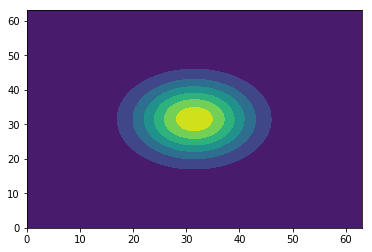

In [9]:
plt.contourf(val.reshape((m, m)))

In [10]:
tm = 0.0
tau = 1e-2
nsteps = 1
nsamples = 500

In [11]:
for _ in range(5):
    t = np.linspace(amin, amax, m)
    x, y = np.meshgrid(t, t)
    w = np.array([x, y])
    w = w.reshape((2, -1))

    res = compute_value(w, tau, nsteps, nsamples, fun)
    res = res.reshape((m, m))
    print(np.sum(res))

    fun = RectBivariateSpline(t, t, res)

    #fun = Rbf(x.flatten(), y.flatten(), res.flatten())
    tm += tau*nsteps
    #print(tm)
    #plt.contourf(x, y, res, 100)
    #plt.colorbar()

346.3974972168329
346.33386636665944
346.4455097904297
346.4158058708556
346.2455871278643


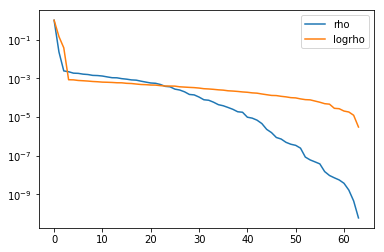

In [12]:
s1 = np.linalg.svd(res)[1]
s2 = np.linalg.svd(np.log(res))[1]
plt.semilogy(s1/s1[0], label='rho')
plt.semilogy(s2/s2[0], label='logrho')
plt.legend()

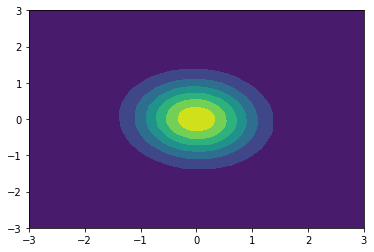

In [13]:
plt.contourf(x, y, res)

In [14]:
np.exp(-tm*np.linalg.eigvals(A))

array([0.95122942, 0.95122942])

In [15]:
amin = -3.0
amax = 3.0
n = 256
d = 2
h_grid = (amax-amin)/(n-1)


In [16]:
def evaluate_approximant(ten, x):
    #Evaluate piecewise-linear interpolant 
    nx = x.shape[0] #Number of points
    core_list = ten.to_list(ten) #To fix it later, stupid syntax
    core_vec = []
    for i in range(x0.d):
        j = np.array((x[:, i] - amin)/h_grid, dtype=np.int)
        j[j<0] = 0
        j[j>=n-1] = n-2 
        xleft = amin + j*h_grid
        xright = amin + (j+1)*h_grid
        alpha = (xright - x[:, i])/h_grid
        core_loc = np.einsum('k,ikj -> kij', alpha, core_list[i][:, j, :])  +  np.einsum('k,ikj -> kij', 1-alpha, core_list[i][:, j+1, :])
        core_vec.append(core_loc)

    mat = np.ones((nx, 1, 1))
    for cr in core_vec:
        mat = np.einsum('kij,kjl->kil', mat, cr)
    mat = np.squeeze(mat)
    return mat
#    mat = mat@cr 


In [17]:
import tt
from tt.cross.rectcross import cross
r = 2
x0 = tt.rand(n, d, r)

def my_fun(ind):
    x = amin + h_grid*ind
    w = logrho0(x.T)
    return w
    
init = cross(my_fun, x0, eps=1e-5, nswp=6, kickrank=1, rf=2)                                                                                                                                                                                                                
#x2 = cross(my_fun, x0, eps=1e-5, nswp=6, kickrank=1, rf=2)                                                                                                                                                                                                                
#x3 = cross(my_fun, x0, eps=1e-5, nswp=6, kickrank=1, rf=2)     

swp: 0/5 er_rel = 1.0e+00 er_abs = 1.9e+03 erank = 4.0 fun_eval: 3072
swp: 1/5 er_rel = 4.5e-16 er_abs = 8.3e-13 erank = 6.0 fun_eval: 8192


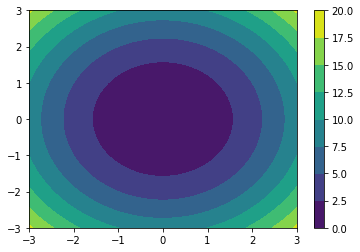

In [18]:
M = 64
t = np.linspace(amin, amax, M)
X, Y = np.meshgrid(t, t)
Xall = np.vstack((X.flatten(), Y.flatten())).T
res = evaluate_approximant(init, Xall).reshape((M, M))
plt.contourf(t, t, res)
plt.colorbar()

In [19]:
nsteps = 1
def compute_value2(x0, tau, nsteps, nsamples, rho_prev):
    x = np.copy(x0)
    K = x.shape[1]
    x = np.repeat(x.reshape((d, -1)), nsamples, axis=1)
    #log_eta = np.zeros(x.shape[1])
    eta = np.ones(x.shape[1])
    for _ in range(nsteps):
        eta = eta * compute_trace(x, tau)
        x =  x + tau*A@x + np.sqrt(tau)*np.random.randn(*x.shape)*noise #Note +before A #Can replace with much better quadrature in the 
        #stochastic noise
    #w = np.exp(-logrho0(x))*eta
    val = evaluate_approximant(rho_prev, x.T)
    val = np.exp(-val)
    w = val*eta
    w = np.reshape(w, (K, nsamples))
    res = np.mean(w, axis=1)
    res = -np.log(res)
    return res

In [20]:
sol = init.copy()

In [21]:
def my_fun2(ind):
    x = amin + h_grid*ind
    res = compute_value2(x.T, tau, nsteps, nsamples, sol)
    return res

nsamples = 100
tau = 8e-3
tm = 0.0
for _ in range(5):
    tm = tm + tau*nsteps
    sol1 = cross(my_fun2, sol, eps=1e-5, nswp=6, kickrank=1, rf=1.1)
    sol1 = sol1.round(1e-2)
    print((sol1-sol).norm()/sol.norm(), tm)

    sol = sol1.copy()

swp: 0/5 er_rel = 8.8e-03 er_abs = 1.6e+01 erank = 10.0 fun_eval: 8192
swp: 1/5 er_rel = 1.0e-02 er_abs = 1.9e+01 erank = 14.0 fun_eval: 20480
swp: 2/5 er_rel = 1.1e-02 er_abs = 2.0e+01 erank = 18.0 fun_eval: 36864
swp: 3/5 er_rel = 1.2e-02 er_abs = 2.3e+01 erank = 22.0 fun_eval: 57344
swp: 4/5 er_rel = 1.4e-02 er_abs = 2.5e+01 erank = 26.0 fun_eval: 81920
swp: 5/5 er_rel = 1.4e-02 er_abs = 2.6e+01 erank = 30.0 fun_eval: 110592
0.008664145094803276 0.008
swp: 0/5 er_rel = 1.0e-02 er_abs = 1.8e+01 erank = 5.0 fun_eval: 4096
swp: 1/5 er_rel = 1.0e-02 er_abs = 1.8e+01 erank = 8.0 fun_eval: 10496
swp: 2/5 er_rel = 1.1e-02 er_abs = 2.1e+01 erank = 12.0 fun_eval: 20736
swp: 3/5 er_rel = 1.2e-02 er_abs = 2.3e+01 erank = 16.0 fun_eval: 35072
swp: 4/5 er_rel = 1.2e-02 er_abs = 2.3e+01 erank = 20.0 fun_eval: 53504
swp: 5/5 er_rel = 1.5e-02 er_abs = 2.7e+01 erank = 24.0 fun_eval: 76032
0.010997463982953521 0.016
swp: 0/5 er_rel = 1.1e-02 er_abs = 2.1e+01 erank = 6.0 fun_eval: 4352
swp: 1/5 er_rel

1439.6994921630148


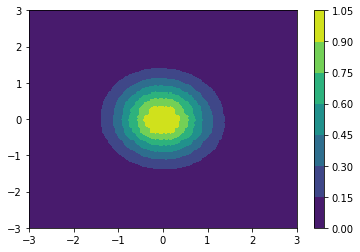

In [22]:
M = 128
t = np.linspace(amin, amax, M)
X, Y = np.meshgrid(t, t)
Xall = np.vstack((X.flatten(), Y.flatten())).T
res = evaluate_approximant(sol, Xall).reshape((M, M))
print(np.sum(np.exp(-res)))
plt.contourf(t, t, np.exp(-res))
plt.colorbar()

In [269]:
x1 = cross(my_fun2, init, eps=1e-5, nswp=6, kickrank=1, rf=1.1)
x2 = cross(my_fun2, init, eps=1e-5, nswp=6, kickrank=1, rf=1.1)
x3 = cross(my_fun2, init, eps=1e-5, nswp=6, kickrank=1, rf=1.1)

swp: 0/5 er_rel = 3.6e+01 er_abs = 4.7e+02 erank = 9.0 fun_eval: 1856
swp: 1/5 er_rel = 2.1e-01 er_abs = 2.7e+00 erank = 13.0 fun_eval: 4672
swp: 2/5 er_rel = 2.2e-01 er_abs = 2.9e+00 erank = 17.0 fun_eval: 8512
swp: 3/5 er_rel = 2.2e-01 er_abs = 3.0e+00 erank = 21.0 fun_eval: 13376
swp: 4/5 er_rel = 2.3e-01 er_abs = 3.0e+00 erank = 25.0 fun_eval: 19264
swp: 5/5 er_rel = 2.3e-01 er_abs = 3.0e+00 erank = 29.0 fun_eval: 26176
swp: 0/5 er_rel = 3.6e+01 er_abs = 4.7e+02 erank = 9.0 fun_eval: 1856
swp: 1/5 er_rel = 1.9e-01 er_abs = 2.6e+00 erank = 13.0 fun_eval: 4672
swp: 2/5 er_rel = 2.0e-01 er_abs = 2.8e+00 erank = 17.0 fun_eval: 8512
swp: 3/5 er_rel = 2.3e-01 er_abs = 3.1e+00 erank = 21.0 fun_eval: 13376
swp: 4/5 er_rel = 2.3e-01 er_abs = 3.0e+00 erank = 25.0 fun_eval: 19264
swp: 5/5 er_rel = 2.2e-01 er_abs = 2.9e+00 erank = 29.0 fun_eval: 26176
swp: 0/5 er_rel = 3.5e+01 er_abs = 4.7e+02 erank = 10.0 fun_eval: 2048
swp: 1/5 er_rel = 2.0e-01 er_abs = 2.8e+00 erank = 14.0 fun_eval: 5120
sw

In [270]:
xx = (x1+x2+x3)*(1.0/3)
xx = xx.round(1e-3)

In [271]:
x3.round(1e-3)

This is a 2-dimensional tensor 
r(0)=1, n(0)=64 
r(1)=30, n(1)=64 
r(2)=1 

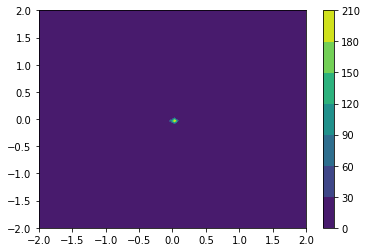

In [168]:
t = np.linspace(amin, amax, n)
x, y = np.meshgrid(t, t)
x4_1 = x4.full()
x4_1 = np.exp(-x4_1)
cf = np.sum(x4_1)*h_grid**2
x4_1 = x4_1/cf
plt.contourf(x, y, x4_1)
plt.colorbar()

## Equation for rho

Suppose $x = F(z)$ is the mapping. The we have

$$\rho(x) dx = \rho(F(z)) \det \frac{dF}{dz} dz,$$



The equation, as far I remember, has the form

$$\frac{d \log \rho}{dt} = \mathrm{Tr} \frac{d z(t)}{ dx}$$

The problem is that mapping "warps the elementary cube". Suppose a 1d case. Then we need to estimate the probability to fall 
into the interval $[x, x+dx]$. The "preimage" of the is is $[F^{-1}(x), F^{-1}(x+dx)]$

thus we need to compute the derivative of the $F^{-1}(x)$ with respect to the final point. 

Still: the likelihood of observing a point is $\log \rho_0 (F^{-1}(x))$. Then we will only need to normalize it.

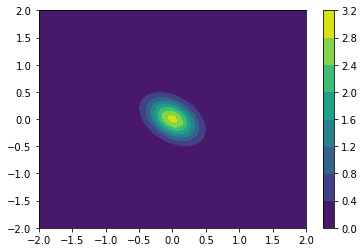

In [125]:
t = np.linspace(amin, amax, n)
x, y = np.meshgrid(t, t)
res = A[0, 0]*x**2+(A[0, 1] + A[1, 0])*x*y + A[1, 1]*y**2
res = res/noise
x4_1 = np.exp(-res)
cf = np.sum(x4_1)*h_grid**2
x4_1 = x4_1/cf
plt.contourf(x, y, x4_1)
plt.colorbar()

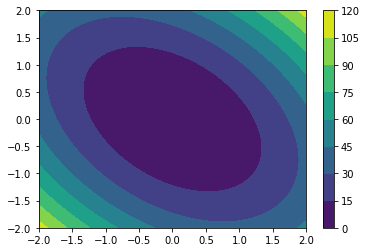

In [126]:
plt.contourf(x, y, res)
plt.colorbar()

## Boxes

We fix the intermediate time steps, and compute the boxes that are needed to compute the final box output.

In order to compute the boxes, we can sample from the initial density a bunch of trajectories, and record the intermediate boxes 
for all time steps; then we will be able to recover all the reasonable sizes.

Then we can fix the box. If the trajectory falls outside the box, we just throw it away from the expectation.

In [320]:
def compute_boxes(w, tau, nsteps, noise):
    #w is d x K
    w1 = w.copy()
    res = []
    for _ in range(nsteps):
        mx = np.mean(w1, axis=1) + 2*np.std(w1, axis=1)
        mn = np.mean(w1, axis=1) - 2*np.std(w1, axis=1)
        res.append([mn, mx])
        w1 = w1 - tau*A@w1 + np.sqrt(tau)*np.random.randn(*w1.shape)*noise
    return res

In [321]:
K = 10000
w = np.random.randn(d, K)
tau = 1e-2
nsteps = 300

res = compute_boxes(w, tau, nsteps, noise)

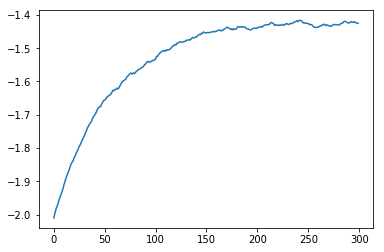

In [322]:
plt.plot([t[0][0] for t in res])